## Notebook to analyze TH Serpinb7
Thalamus, smallish sized subclass group. Seems to specifically label anterodorsal thalamus

In [1]:
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import scipy.io
import scipy.sparse
import matplotlib.pyplot as plt

In [2]:
# Function to create volcano plots
def plotVolcano(dataObj, indx = 0, thresh = 10, label = ["top"]):
    """ Create a volcano plot for given log fold changes and p values. Takes annData 
    object with "rank_gene_groups" field as input. Indx denotes group to look at.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Clean inputs, check that label is a list rather than string
    if type(label) == str:
        label = [label]
    
    # Get class names
    rankGenes = dataObj.uns["rank_genes_groups"]
    groups = rankGenes["names"].dtype.names
    
    # If indx is an int, find appropriate string conversion
    if type(indx) == int:
        indx = groups[indx]
    
    rankGenes = dataObj.uns["rank_genes_groups"]
    groups = rankGenes["names"].dtype.names
    pVal = rankGenes["pvals_adj"][indx] #pvals_adj
    logFoldChange = rankGenes["logfoldchanges"][indx]

    # Adjust unplottable
    pVal[pVal == 0] = min(pVal[pVal > 0])
    pVal = -np.log10(pVal)
    # Determine how to color points
    upExpressed = (logFoldChange > 3) & (pVal > thresh)
    downExpressed = (logFoldChange < -3) & (pVal > thresh)
    belowThresh = ~(upExpressed | downExpressed)
    
    # Plot genes that fall above and below baseline
    fig = plt.subplots()
    plt.grid(True, which = "both")
    plt.plot(logFoldChange[belowThresh], pVal[belowThresh], '.', color='gray', markersize = 2)
    plt.plot(logFoldChange[upExpressed], pVal[upExpressed], '.', color='green', markersize = 2)
    plt.plot(logFoldChange[downExpressed], pVal[downExpressed], '.', color='blue', markersize = 2)
    plt.xlabel("Log2 Fold Change")
    plt.ylabel("- Log10 ( pVal ) ")
    
    # Check for annotation requests. Default behavior is to annotate the top X genes, otherwise plot requested genes
    if label == ["top"]:
        for i in [0]:
            plt.annotate(rankGenes["names"][indx][i], [logFoldChange[i],pVal[i]])
            plt.annotate(rankGenes["names"][indx][-(i + 1)], [logFoldChange[-(i + 1)],pVal[-(i + 1)]])
    else:
        for i in range(len(label)):
            geneIndx = rankGenes["names"][indx].tolist().index(label[i])
            plt.annotate(label[i], [logFoldChange[geneIndx], pVal[geneIndx]])
    plt.title(indx + ' vs ' + rankGenes["params"]["reference"] + ' reference')
    return fig

# function to create a mask dictionary for umap plotting
def create_mask_dict(names,show_name):
    mask_dict = {}
    for name in names:
        if str(name) == show_name:
            mask_dict[name] = "red"
        else:
            mask_dict[name] = "lightgray"
    return mask_dict

In [3]:
# Load in pre-processed data from glutamatergic class designation, subclass to all rank_gene_groups already performed
gluData = sc.read("../Data/gluData.h5ad")

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [4]:
# TH Serpinb7 is a medium large sized subclass within dataset
gluTypes = gluData.obs.subclass_label.unique()
gluCounts = pd.DataFrame([sum(gluData.obs.subclass_label == name) for name in gluTypes], columns= ["Count"], index = gluTypes)
gluCounts = gluCounts.sort_values(by = "Count", ascending=False)
gluCounts

,Count
TH Prkcd_Grin2c,23362
TH_Rxfp1_Epb4,10411
TH PVT_Ntrk1,5419
TH/HY Gbx2 Zim1,5006
TH MH_Tac2,4405
TH AV_Col27a1,3011
TH PF_Fzd5,2500
TH LH_Pou4f1_Sox1,1346
TH Tfap2d,774
TH Serpinb7,398


In [17]:
# Create a dataframe with list of gene scores, pvals, logfoldchanges, percentage expression
indx = "TH Serpinb7"
genesRanked = pd.DataFrame(
        {key: gluData.uns["rank_genes_groups"][key][indx]
        for key in ['names', 'pvals', 'scores', 'logfoldchanges']})
pts = gluData.uns["rank_genes_groups"]["pts"][indx][genesRanked.names].reset_index(drop=True).rename("pts")
pts_rest = gluData.uns["rank_genes_groups"]["pts_rest"][indx][genesRanked.names].reset_index(drop=True).rename("pts_rest")
pts_diff = pd.Series(pts - pts_rest, name="pts_diff")
genesRanked = pd.concat([genesRanked, pts, pts_rest, pts_diff], axis=1)
genesRanked = genesRanked.sort_values(by=["scores"], ascending=False)
genesRanked

,names,pvals,scores,logfoldchanges,pts,pts_rest,pts_diff
0,C1ql2,4.925494e-257,34.246452,15.828676,0.994975,0.015860,0.979115
1,Adcy2,2.583969e-248,33.655579,9.598422,0.997487,0.412523,0.584964
2,Syndig1l,3.468131e-248,33.646839,7.775938,1.000000,0.503926,0.496074
3,Rspo3,1.487238e-247,33.603580,11.127617,1.000000,0.189883,0.810117
4,Slc44a5,2.026875e-244,33.388302,10.273835,0.997487,0.273224,0.724264
...,...,...,...,...,...,...,...
23426,Rasgef1b,4.871736e-216,-31.372032,-8.563962,0.341709,0.941653,-0.599944
23427,Robo1,3.132144e-222,-31.822798,-3.902689,0.992462,0.997067,-0.004605
23428,Nlgn1,3.644924e-230,-32.391251,-7.626560,0.761307,0.991429,-0.230122
23429,Ntm,1.856771e-230,-32.412048,-8.607791,0.673367,0.985562,-0.312196


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'TH Serpinb7 vs rest reference'}, xlabel='Log2 Fold Change', ylabel='- Log10 ( pVal ) '>)

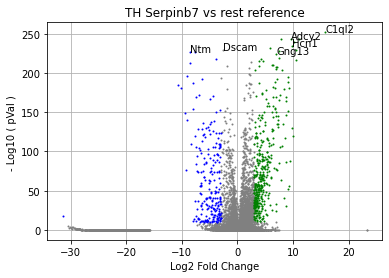

In [14]:
# Create volcano plot
plotVolcano(gluData,indx,label=["C1ql2","Adcy2","Hcn1","Gng13", "Dscam", "Ntm"])

In [49]:
# Take top 500 "score" genes
genesRanked = genesRanked.sort_values(by=["scores"], ascending=False, key=abs)
genesFiltered = genesRanked.iloc[0:500,:]
genesFiltered = genesFiltered.sort_values(by=["pts_diff"], ascending=False)
genesFiltered

,names,pvals,scores,logfoldchanges,pts,pts_rest,pts_diff
0,C1ql2,4.925494e-257,34.246452,15.828676,0.994975,0.015860,0.979115
7,Stk32b,6.740722e-233,32.584770,10.558144,0.972362,0.098270,0.874092
27,Scn7a,7.878339e-199,30.083864,9.132226,0.912060,0.069149,0.842911
38,Col27a1,2.082547e-184,28.960289,9.256069,0.924623,0.095302,0.829321
12,Megf11,6.553890e-221,31.727190,10.508489,0.984925,0.158936,0.825989
...,...,...,...,...,...,...,...
23415,Cacng4,3.703733e-172,-27.970594,-7.391788,0.258794,0.877000,-0.618206
23408,Pcdh7,6.667521e-152,-26.252645,-9.420115,0.168342,0.800193,-0.631851
23419,Foxp2,7.022627e-185,-28.997755,-10.183712,0.226131,0.875946,-0.649816
23404,Calb1,1.160583e-142,-25.430489,-9.154019,0.103015,0.768754,-0.665739


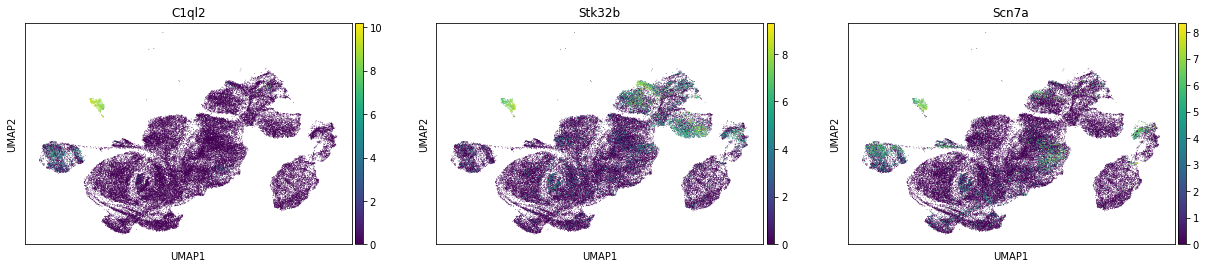

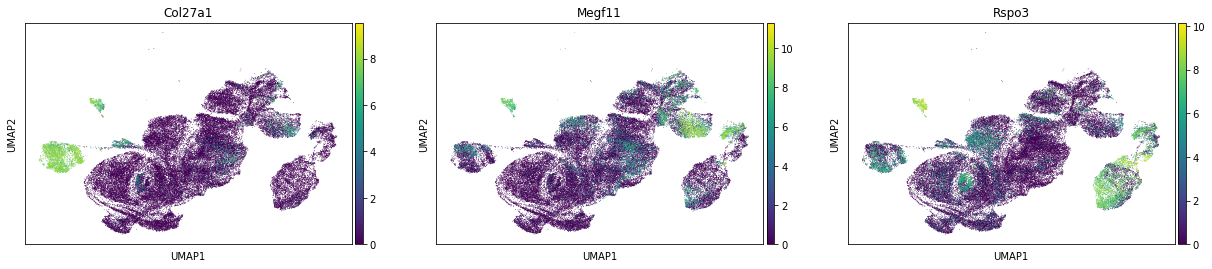

In [16]:
# Plot expression of several potential marker genes
sc.pl.umap(gluData, color = genesFiltered["names"][0:3])
sc.pl.umap(gluData, color = genesFiltered["names"][3:6])

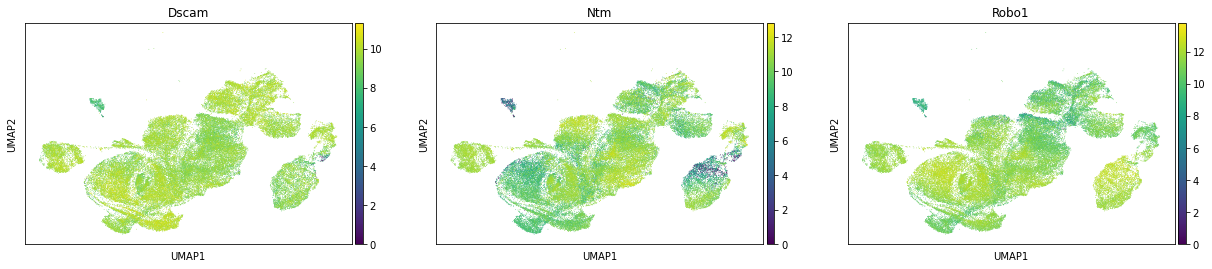

In [19]:
# Plot expression of several genes which are expressed more highly elsewhere
sc.pl.umap(gluData, color = ["Dscam", "Ntm", "Robo1"])

In [42]:
# Look at marker gene overlap
markerGenes = {
    'Upregulated' : genesFiltered["names"][:5].tolist(),
    'Neutral' : genesFiltered["names"][-5:].tolist(),
    'Downregulated' : ["Zfp462","Calb1","Foxp2","Pcdh7","Cacng4"],
}
markerOverlap = sc.tl.marker_gene_overlap(gluData,markerGenes,method="overlap_count", top_n_markers=50, inplace=False)
markerOverlap

,HY Foxa1,HY Pitx2,TH AV_Col27a1,TH LH_Pou4f1_Sox1,TH MH_Tac2,TH PF_Fzd5,TH PVT_Ntrk1,TH Pitx2,TH Prkcd_Grin2c,TH Serpinb7,TH Tfap2d,TH/HY Gbx2 Fmo1,TH/HY Gbx2 Zim1,TH/HY Pth2,TH_Rxfp1_Epb4
Upregulated,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0
Neutral,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
Downregulated,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


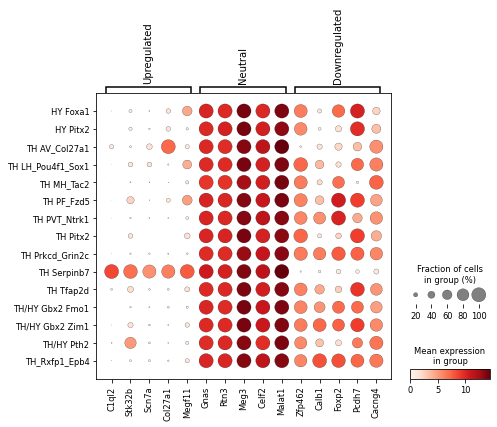

In [43]:
sc.pl.dotplot(gluData,markerGenes,"subclass_label", dendrogram = False)

## TH Serpinb7 subcluster analysis
Only one cluster within the TH Serpinb7 subclass

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


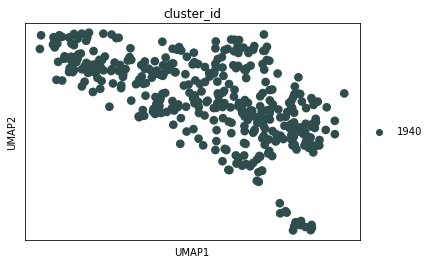

In [20]:
# Index by cell class
indx = "TH Serpinb7"
clData = gluData[gluData.obs.subclass_label == indx]
color_dict = dict(zip(clData.obs["cluster_id"],clData.obs["cluster_color"]))
sc.pl.umap(clData, color="cluster_id",palette=color_dict)

In [21]:
# Get counts of each cluster type
clTypes = clData.obs.cluster_id.unique()
clCounts = pd.DataFrame([sum(clData.obs.cluster_id == name) for name in clTypes], columns= ["Count"], index = clTypes)
clCounts = clCounts.sort_values(by = "Count", ascending=False)
clCounts

,Count
1940,398


## Other stuff

In [ ]:
# Link to Allen ISH
# C1ql2, clearly and specifically labels anterodorsal region of thalamus
https://mouse.brain-map.org/experiment/siv?id=71587929&imageId=71425183&initImage=ish&coordSystem=pixel&x=2312.5&y=2096.5&z=1

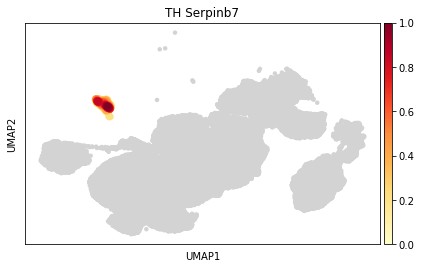

In [24]:
# Subclass embedding density
sc.tl.embedding_density(gluData, basis="umap", groupby="subclass_label")
sc.pl.embedding_density(gluData, basis="umap", key="umap_density_subclass_label", group=indx)